In [106]:
import os
import torch
import torch.nn as nn
import einops
from torchtyping import TensorType

In [107]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data',  
    train=True,     
    download=True,  
    transform=transform
)


test_dataset = datasets.MNIST(
    root='./data',
    train=False,    
    download=True,
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [108]:
import torch.utils.data.dataloader as dataloader

train_loader = dataloader.DataLoader(
    train_dataset,
    32
)


In [109]:
from torchvision.transforms import CenterCrop
import torch
from typing import Tuple, Callable, Optional, Dict, List

class VariationalAutoEncoder(nn.Module):
    def __init__(
            self, 
            latent: int,
            reconstruction_loss: Callable[..., torch.Tensor] = nn.MSELoss()
        ):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1,
                32,
                kernel_size=6,
                stride=2,
                padding=2
            ), # (B, 32, 14, 14)
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(
                32,
                64,
                kernel_size=6,
                stride=2,
                padding=2
            ), # (B, 64, 7, 7)
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(
                64,
                128,
                kernel_size=6,
                stride=2,
                padding=2,
            ),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),

            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.LeakyReLU(),
            # nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),

            nn.ConvTranspose2d(
                128, 
                64,
                kernel_size=6,
                stride=2,
                padding=2
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                64, 
                32,
                kernel_size=6,
                stride=2,
                padding=2
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(
                32, 
                1,
                kernel_size=6,
                stride=2,
                padding=2
            ),
            nn.Tanh(),
            CenterCrop(28),
        )

        self.latent_size = latent
        self.latent_mu = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, latent)
        )
        self.latent_log_var = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, latent)
        )
        self.reconstruction_criterion = reconstruction_loss

    def __kl_divergence_loss(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        VAE에서 학습된 잠재 분포와 표준 정규 분포 사이의 KL 발산 손실을 계산합니다.
        
        Args:
            mu: 학습된 잠재 분포의 평균값
            log_var: 학습된 잠재 분포의 로그 분산값
            
        Returns:
            KL 발산 손실항
        """
        # N(mu, sigma)와 N(0, 1) 사이의 KL 발산
        # 잠재 차원에 대해서는 합산하고 배치 차원에 대해서는 평균을 계산
        # 현재 구현:
        # 1. 잠재 차원에 대해 합산 (dim=1)
        # 2. 그 다음 배치 차원에 대해 평균 계산
        # 이렇게 구현하는 이유:
        # - KL 발산은 독립적인 차원에 대해 더해지므로 잠재 차원에 대해 합산해야 함
        # - 샘플당 손실을 구하기 위해 배치 차원에 대해서는 평균을 계산해야 함
        # 따라서 이 구현 방식을 유지
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()
        return kl_div

    def __sampler(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(0.5 * log_var)
    
    def Encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        out = self.encoder(x)
        mu = self.latent_mu(out)
        log_var = self.latent_log_var(out)
        return self.__sampler(mu, log_var), mu, log_var

    
    def Decode(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-1] == self.latent_size, "latent size does not match"
        return self.decoder(x)

    def forward(self, x: torch.Tensor, epoch: int = 0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        encoded, mu, log_var = self.Encode(x)
        decoded = self.Decode(encoded)
        loss = None

        if self.training:
            beta = min(1, epoch / 500)
            reconstruction_loss = self.reconstruction_criterion(decoded, x)
            regulation_loss = self.__kl_divergence_loss(mu, log_var)
            loss = reconstruction_loss + beta * regulation_loss
        
        return encoded, decoded, loss

In [110]:
import torch.utils

def project_to_principal_axis(
    dataset: TensorType["batch", "features"],
    output_features: int 
) -> TensorType["batch", "output_features"]:
    sigma: TensorType["batch", "features", "features"] = dataset.unsqueeze(-1) @ dataset.unsqueeze(1)
    mean_sigma: TensorType["features", "features"] = einops.reduce(sigma, "b f1 f2 -> f1 f2", "mean")
    eigen_values, eigen_vectors = torch.linalg.eigh(mean_sigma)
    principal_components = eigen_vectors[:, -output_features:]
    projected_data = dataset @ principal_components

    return projected_data

In [113]:
model = VariationalAutoEncoder(6)

optim = torch.optim.AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5, verbose=True)

In [114]:
EPOCH = 10

model.train()
for epoch in range(EPOCH):
    loss_log = []
    for batch in train_loader:
        optim.zero_grad()
        _, _, loss = model(batch[0])
        loss.backward()
        optim.step()
        loss_log.append(loss)
    epoch_loss = einops.reduce(
        torch.stack(loss_log),
        "i ->",
        "mean"
    )
    print(f"Avg loss in epoch {epoch}: {epoch_loss.item()}")
    scheduler.step(epoch_loss)
        

Avg loss in epoch 0: 0.07672411948442459
Avg loss in epoch 1: 0.03918404132127762
Avg loss in epoch 2: 0.034756649285554886
Avg loss in epoch 3: 0.03240305185317993
Avg loss in epoch 4: 0.030876027420163155
Avg loss in epoch 5: 0.029750406742095947
Avg loss in epoch 6: 0.028860267251729965
Avg loss in epoch 7: 0.028121283277869225
Avg loss in epoch 8: 0.027485042810440063
Avg loss in epoch 9: 0.02693343535065651


In [115]:
test_dataloader = dataloader.DataLoader(
    test_dataset,
    1000
)

In [116]:
batch, label = next(iter(test_dataloader))
data, _, _ = model.Encode(batch)

projected_data = project_to_principal_axis(data, 2)

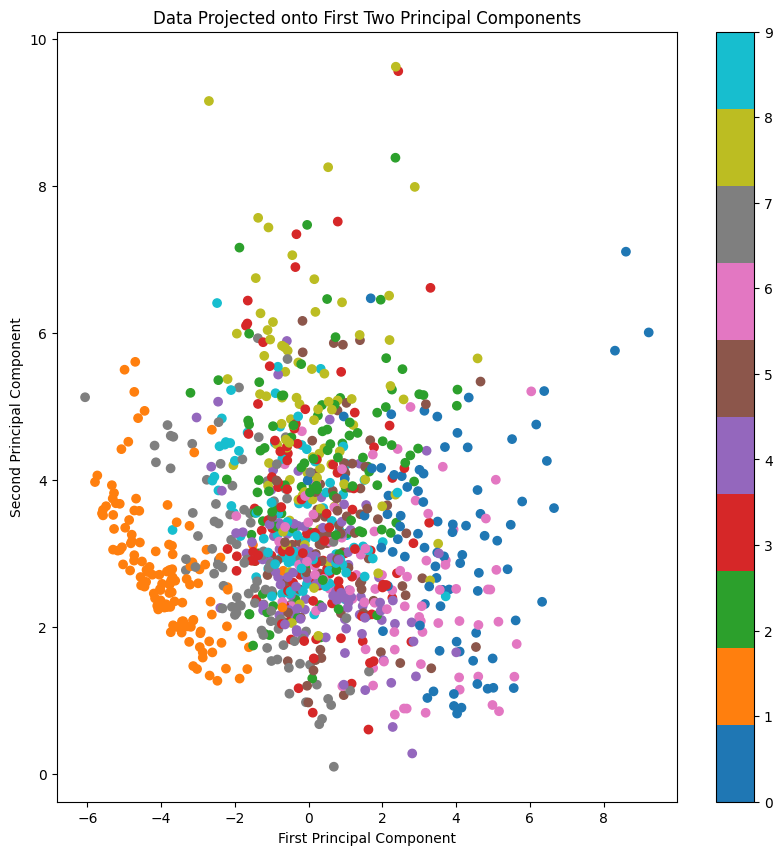

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(projected_data[:,0].detach().numpy(), projected_data[:,1].detach().numpy(), c=label, cmap='tab10')
plt.colorbar()
plt.title('Data Projected onto First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()